In [ ]:
from google.colab import drive
drive.mount('/gdrive')

In [ ]:
!pip install konlpy
!pip install kss

In [ ]:
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git

In [ ]:
cd Mecab-ko-for-Google-Colab

In [ ]:
!bash install_mecab-ko_on_colab190912.sh

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


train_shape : (12984, 3200, 1) / (12984, 10)
test_shape : (1443, 3200, 1) / (1443, 10)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 3200, 16)          640       
_________________________________________________________________
bidirectional_1 (Bidirection (None, 3200, 16)          1600      
_________________________________________________________________
bidirectional_2 (Bidirection (None, 32)                4224      
_________________________________________________________________
dense (Dense)                (None, 10)                330       
_________________________________________________________________
activation (Activation)      (None, 10)                0         
Total params: 6,794
Trainable params: 6,794
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1024
12/12 [=============

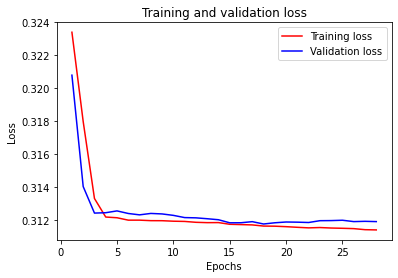

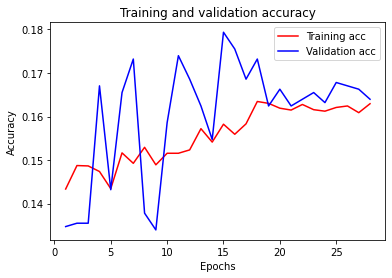

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
              precision    recall  f1-score   support

           0       0.16      0.06      0.08       210
           1       0.16      0.51      0.24       225
           2       0.00      0.00      0.00        44
           3       0.00      0.00      0.00       128
           4       0.00      0.00      0.00        76
           5       0.00      0.00      0.00        82
           6       0.22      0.03      0.05       204
           7       0.15      0.49      0.23       190
           8       0.00      0.00      0.00        52
           9       0.00      0.00      0.00       232

    accuracy                           0.16      1443
   macro avg    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Activation, Bidirectional
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder;
LE = LabelEncoder()
from sklearn.metrics import classification_report
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Mecab


def bilstm():
    model = Sequential()
    model.add(Bidirectional(LSTM(2 ** 3, return_sequences=True), input_shape=(max_len*100, 1)))
    model.add(Bidirectional(LSTM(2 ** 3, return_sequences=True)))
    model.add(Bidirectional(LSTM(2 ** 4, return_sequences=False)))

    model.add(Dense(10))
    model.add(Activation('softmax'))
    adam = optimizers.Adam(lr=0.001)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    model.summary()
    early_stopping = EarlyStopping(patience=10)
    history = model.fit(x_train, y_train, validation_split=0.1, epochs=epochs, batch_size=batch_size, verbose=1,
                        callbacks=[early_stopping])

    return model, history


if __name__ == "__main__":
    max_len = 32
    epochs = 2 ** 10
    batch_size = 2 ** 10

    mecab = Mecab()

    model = Word2Vec.load('/gdrive/My Drive/한양대학교/2020 프로젝트 학기제/TEST/word2vec')

    depression_dataset_path = r'/gdrive/My Drive/한양대학교/2020 프로젝트 학기제/TEST/depression_dataset_맞춤법O.csv'

    depression_dataset = pd.read_csv(depression_dataset_path, encoding='cp949')
    depression_dataset = depression_dataset[depression_dataset['label_1'] == 'Y']

    df = []

    for i in range(len(depression_dataset)):
        df.append(mecab.morphs(depression_dataset.iloc[i, 0]))

    for i in range(len(df)):
        for j in range(len(df[i])):
            try:
                df[i][j] = model.wv.get_vector(df[i][j]).tolist()
            except:
                df[i][j] = False

    for i in range(len(df)):
        while False in df[i]:
            df[i].remove(False)

    for i in range(len(df)):
        if len(df[i]) >= max_len:
            df[i] = df[i][-max_len:]
        else:
            for j in range(max_len - len(df[i])):
                df[i].insert(0, 0)

    for i in range(len(df)):
        for j in range(len(df[i])):
            if df[i][j] == 0:
                df[i][j] = [0] * 100

    depression_dataset['label_2'] = LE.fit_transform(depression_dataset['label_2'])

    x_train, x_test, y_train, y_test = train_test_split(df, depression_dataset['label_2'], test_size=0.1,
                                                        random_state=42)

    x_train = np.array(x_train).reshape((len(x_train), max_len * 100, 1))
    x_test = np.array(x_test).reshape((len(x_test), max_len * 100, 1))

    y_true = copy.deepcopy(y_test)
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)

    print('train_shape : {} / {}'.format(x_train.shape, y_train.shape))
    print('test_shape : {} / {}'.format(x_test.shape, y_test.shape))

    model, history = bilstm()

    scores = model.evaluate(x_test, y_test)
    print(scores)
    print("정확도: %.2f%%" % (scores[1] * 100))

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.figure()
    plt.plot(epochs, acc, 'r', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    y_true = list(y_true)
    y_pred = model.predict_classes(x_test)
    y_pred = list(y_pred)

    print(classification_report(y_true, y_pred))
    print(pd.crosstab(pd.Series(y_true), pd.Series(y_pred), rownames=['True'], colnames=['Predicted']))